Human in Loop

In [ ]:
import os

In [2]:
from dotenv import load_dotenv
load_dotenv()
groq_api = os.getenv('groq_api_key')
tavily_search_api = os.getenv('tavily_api_key')

In [3]:
from typing import TypedDict
from typing_extensions import Annotated


from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import MemorySaver

from langchain.chat_models import init_chat_model
from langchain_core.tools import tool

from langchain_tavily  import TavilySearch


In [4]:
class State(TypedDict):
    messages : Annotated[list, add_messages]

llm = init_chat_model(model= 'groq:llama-3.1-8b-instant')
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x0000020787BC9D30>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000020787BCAA50>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [5]:

tool1 = TavilySearch(max_results=2)


@tool
def human_assistance(querry: str):
    """request assistance from human"""
    human_response = interrupt({'querry': querry})
    return human_response['data']

tools = [tool1, human_assistance ]
llm_tool = llm.bind_tools(tools)


def chatbot(state: State):
    return {'messages': llm_tool.invoke(state['messages'])}



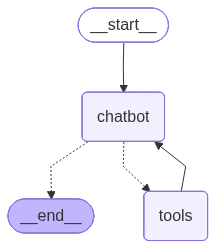

In [6]:
memmory = MemorySaver()

#buid graph
graph_builder = StateGraph(State)

#add node
graph_builder.add_node('chatbot', chatbot)
tool_node = ToolNode(tools =tools)
graph_builder.add_node('tools', tool_node)
#add edge
graph_builder.add_edge(START, 'chatbot')
graph_builder.add_conditional_edges('chatbot', tools_condition)
graph_builder.add_edge('tools', 'chatbot')

graph = graph_builder.compile(checkpointer=memmory)
graph



In [7]:
config = {'configurable': {'thread_id': '1'}}
config3 = {'configurable': {'thread_id': '3'}}

In [8]:
user_input = "I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?"


In [9]:
events = graph.stream(
    {"messages": user_input},
    config3,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (5kn4batac)
 Call ID: 5kn4batac
  Args:
    querry: Building an AI agent, need expert guidance and assistance.
================================== Ai Message ==================================
Tool Calls:
  human_assistance (5kn4batac)
 Call ID: 5kn4batac
  Args:
    querry: Building an AI agent, need expert guidance and assistance.


In [10]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={'data' : human_response})
events = graph.stream(human_command, config3, stream_mode= 'values')

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (5kn4batac)
 Call ID: 5kn4batac
  Args:
    querry: Building an AI agent, need expert guidance and assistance.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fas8gn158)
 Call ID: fas8gn158
  Args:
    query: Building an AI agent, LangGraph
    topic: general
  tavily_search (10yr2at39)
 Call ID: 10yr2at39
  Args:
    query: building AI agent with LangGraph
    search_depth: advanced
================================= Tool Message =================================
Name: tavily_search

{"query": "building AI agent with LangGraph", "follow_up_questions":